### 1. Setup

To prepare your environment, you need to install some packages and enter credentials for the Watson services.

### 1.1 Install the necessary packages

Install IBM Cloud Object Storage Client:

In [1]:
#!pip install --upgrade setuptools 

In [2]:
#!pip install ibm-cos-sdk

In [3]:
#!pip install --upgrade tensorflow

In [4]:
#!pip install --upgrade scikit-image

In [5]:
#!pip install pycm==2.3

#### Now restart the kernel by choosing Kernel > Restart.

### 1.2 Import packages and libraries

Import the packages and libraries that you'll use:

### 2. Configuration

Add configurable items of the notebook below

### 2.1 Add your service credentials for Object Storage

You must create Object Storage service on IBM Cloud. To access data in a file in Object Storage, you need the Object Storage authentication credentials. Insert the Object Storage Streaming Body credentials and ensure the variable is referred as streaming_body_1 in the following cell after removing the current contents in the cell.

In [6]:
import sys
import os, random
import numpy as np
import pandas as pd
import PIL
import keras
import itertools
from PIL import Image
import ibm_boto3
from botocore.client import Config
from IPython.display import clear_output
from pycm import *

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from skimage import feature, data, io, measure, transform
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 


Using TensorFlow backend.
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [8]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_2c8934dd938a40f5a513be20d8d2b6d7 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='dSIwl5YKMREIWPXR-RYulC7Q5UxV3scnFf2MiOhVJSYJ',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_2c8934dd938a40f5a513be20d8d2b6d7.get_object(Bucket='savethevineyard-donotdelete-pr-yqbwz95hmcxjfu', Key='datasetWS_DvsEvsHvsM_512-512.zip')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 



### 2.2 Global Variables

Enter the batch size for training, testing and validation dataset

In [9]:
batch_size_train = 20
batch_size_test = 12
batch_size_val = 24

num_classes= 4
STANDARD_SIZE=(224,224)

## 3. Storage

### 3.1 Extract the Dataset

Input the zip file from object storage and extract the data onto the /home/dsxuser/work folder

In [10]:
from io import BytesIO
import zipfile

zip_ref = zipfile.ZipFile(BytesIO(streaming_body_1.read()),'r')
paths = zip_ref.namelist()
classes_required=[]
for path in paths:
    zip_ref.extract(path)
    temp=path.split('/')
    if len(temp) > 3:
        if temp[2] not in classes_required:
            classes_required.append(temp[2])
print(classes_required)
zip_ref.close()

['dry', 'esca', 'healthy', 'mite']


## 4. Classification

### 4.1 Create the Dataset

In [11]:
'''Converting Data Format according to the backend used by Keras
'''
datagen=keras.preprocessing.image.ImageDataGenerator(data_format=K.image_data_format())

In [12]:
'''Input the Training Data'''
train_path = '/home/dsxuser/work/datasetWS_DvsEvsHvsM_512-512/training_set/'
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), classes=classes_required, batch_size=batch_size_train, shuffle=False)
type(train_batches)

Found 200 images belonging to 4 classes.


keras.preprocessing.image.DirectoryIterator

In [13]:
'''Input the Test Data'''
test_path = '/home/dsxuser/work/datasetWS_DvsEvsHvsM_512-512/test_set/'
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), classes=classes_required, batch_size=batch_size_test, shuffle=False)

Found 48 images belonging to 4 classes.


In [14]:
test_batches_pred = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), classes=classes_required, batch_size=48, shuffle=False)

Found 48 images belonging to 4 classes.


In [15]:
'''Input the Validation Data'''
val_path = '/home/dsxuser/work/datasetWS_DvsEvsHvsM_512-512/validation_set/'
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), classes=classes_required, batch_size=batch_size_val, shuffle=False)

Found 24 images belonging to 4 classes.


In [16]:
train_imgs, train_labels = next(train_batches)
train_labels

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]], dtype=float32)

In [17]:
y_train= [ np.where(r==1)[0][0] for r in train_labels ]
y_train

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
test_imgs, test_labels = next(test_batches_pred)
test_labels

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  

In [19]:
y_test= [ np.where(r==1)[0][0] for r in test_labels ]
y_test

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [20]:
val_imgs, val_labels = next(val_batches)
val_labels

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.]], dtype=float32)

In [21]:
y_val= [ np.where(r==1)[0][0] for r in val_labels ]
y_val

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3]

### 4.2 Build the Model

In [22]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467904/553467096 [==============================] - 10s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

In [23]:
#This is a Keras Functional API need to convert to sequential
type(vgg16_model) 
#Iterate over the functional layers and add it as a stack
model = Sequential() 
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
#Since the model is already trained with certain weights,
# we dont want to change it. Let it be the same
for layer in model.layers: 
    layer.trainable = False

In [26]:
model.add(Dense(4, activation='softmax')) # Add the last layer
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_learning = PlotLearning()

In [28]:
# Complie the model
model.compile(Adam(lr=.00015), 
              loss='categorical_crossentropy', metrics=['accuracy'])

### 4.3 Train the Model

The model will take about 135 minutes to train.

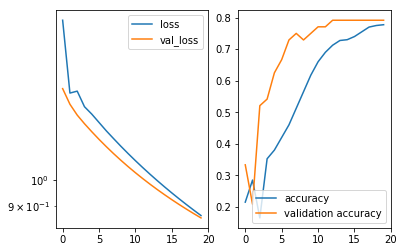

In [29]:
model.fit_generator(train_batches, steps_per_epoch=20, 
                    validation_data=test_batches, 
                    validation_steps=12, epochs=20, 
                    verbose=1, shuffle=False, 
                    callbacks=[plot_learning]) 

In [30]:
#model.fit_generator(train_batches, steps_per_epoch=20, validation_split=0.2, shuffle=True, validation_steps=12, epochs=10, verbose=1)

### 4.4 Test the Model 

In [31]:
model_result_path = "/home/dsxuser/work/class_4_CNN_model_DvsEvsHvsM_224_224.h5"
model.save(model_result_path)

In [32]:
model.save_weights('/home/dsxuser/work/4_class_CNN_model_DvsEvsHvsM_224-224_weights.h5')

Functions for testing the model.

predict_generator takes your test data and gives you the output.

evaluate_generator uses both your test input and output. It first predicts output using training input and then evaluates performance by comparing it against your test output. So it gives out a measure of performance, i.e. accuracy in your case.

In [33]:
scores_train = model.evaluate_generator(generator = train_batches, steps=10)
print("Loss = ", scores_train[0], ", Accuracy = ", scores_train[1])

Loss =  0.807524615526 , Accuracy =  0.834999990463


In [34]:
scores_test = model.evaluate_generator(generator = test_batches_pred, steps=1)
print("Loss = ", scores_test[0], ", Accuracy = ", scores_test[1])

Loss =  0.858065828681 , Accuracy =  0.791666656733


In [35]:
scores_val = model.evaluate_generator(generator = val_batches, steps=1)
print("Loss = ", scores_val[0], ", Accuracy = ", scores_val[1])

Loss =  0.78373259306 , Accuracy =  0.791666686535


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### 4.4 Accuracy Testing

For each of the images the notebook ran predictions and probability of each of them belonging to different classes were listed. 

In [37]:
predictions_test = model.predict_generator(test_batches_pred, steps=1, verbose=0)
predictions_test

array([[ 0.60288328,  0.15206151,  0.10259564,  0.1424596 ],
       [ 0.65529847,  0.06606268,  0.0473823 ,  0.23125657],
       [ 0.52396363,  0.18494879,  0.09439042,  0.19669713],
       [ 0.34830919,  0.38653472,  0.15007482,  0.11508133],
       [ 0.64447534,  0.14690341,  0.09481985,  0.11380144],
       [ 0.49745184,  0.21426354,  0.12093208,  0.1673526 ],
       [ 0.60755736,  0.06825219,  0.04523856,  0.27895188],
       [ 0.60183978,  0.03529785,  0.01628444,  0.34657797],
       [ 0.7002182 ,  0.07840011,  0.03603252,  0.18534915],
       [ 0.68703353,  0.06944428,  0.04205746,  0.20146476],
       [ 0.16852936,  0.3860504 ,  0.28431112,  0.16110916],
       [ 0.50467032,  0.25145391,  0.14019197,  0.10368379],
       [ 0.05022447,  0.45802832,  0.38967171,  0.10207547],
       [ 0.04642318,  0.44103837,  0.34607074,  0.16646773],
       [ 0.07137246,  0.51765883,  0.269714  ,  0.14125469],
       [ 0.06515186,  0.48985356,  0.28064454,  0.16435002],
       [ 0.06871932,  0.

In [38]:
y_pred_test =[]
for i in range(len(predictions_test)):
    y_pred_test.append(np.argmax(predictions_test[i]))
print(y_pred_test)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3]


In [39]:
ctr_test=0
for i in range(len(y_pred_test)):
    if y_pred_test[i] == y_test[i]:
        ctr_test=ctr_test+1
res_test = ctr_test/len(y_pred_test)*100
print(res_test)

79.16666666666666


In [40]:
predictions_val = model.predict_generator(val_batches, steps=1, verbose=0)
predictions_val

array([[ 0.53305978,  0.22866896,  0.19061516,  0.04765606],
       [ 0.7148596 ,  0.09326771,  0.03664297,  0.15522978],
       [ 0.64672405,  0.08596595,  0.06173695,  0.20557307],
       [ 0.57946956,  0.09386282,  0.07527572,  0.25139186],
       [ 0.27794102,  0.37584284,  0.26244104,  0.08377509],
       [ 0.5284878 ,  0.10149927,  0.0770968 ,  0.29291609],
       [ 0.16954659,  0.4468742 ,  0.20365177,  0.17992748],
       [ 0.22535077,  0.34686145,  0.17235331,  0.25543451],
       [ 0.10419952,  0.34532425,  0.43785435,  0.11262186],
       [ 0.04213796,  0.32767823,  0.4839009 ,  0.14628281],
       [ 0.29829639,  0.19284563,  0.08927753,  0.41958052],
       [ 0.14273748,  0.51325691,  0.13638692,  0.20761874],
       [ 0.04950129,  0.2280263 ,  0.58227456,  0.14019781],
       [ 0.1358663 ,  0.31720635,  0.38688126,  0.16004607],
       [ 0.11920673,  0.27699181,  0.45795655,  0.14584492],
       [ 0.1536611 ,  0.27362376,  0.40435755,  0.16835748],
       [ 0.05808711,  0.

In [41]:
y_pred_val=[]
for i in range(len(predictions_val)):
    y_pred_val.append(np.argmax(predictions_val[i]))
print(y_pred_val)

[0, 0, 0, 0, 1, 0, 1, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3]


In [42]:
#plots(val_imgs, titles=y_pred_val)
ctr=0
for i in range(len(y_pred_val)):
    if y_pred_val[i] == y_val[i]:
        ctr=ctr+1
res = ctr/len(y_pred_val)*100
print(res)

79.16666666666666


### 4.5 Confusion matrix

Confusion matrix for test dataset.

In [43]:
# confusion matrix for test data
y_actu_test = y_test

In [44]:
y_pred_test = y_pred_test

In [45]:
cm_test = ConfusionMatrix(actual_vector=y_actu_test, predict_vector=y_pred_test) 

In [46]:
cm_test.classes

[0, 1, 2, 3]

In [47]:
cm_test.table

{0: {0: 10, 1: 2, 2: 0, 3: 0},
 1: {0: 2, 1: 9, 2: 0, 3: 1},
 2: {0: 0, 1: 0, 2: 10, 3: 2},
 3: {0: 2, 1: 0, 2: 1, 3: 9}}

In [48]:
cm_test.print_matrix()

Predict  0        1        2        3        
Actual
0        10       2        0        0        

1        2        9        0        1        

2        0        0        10       2        

3        2        0        1        9        




Confusion matrix for validation dataset.

In [49]:
# confusion matrix for test data
y_actu_val = y_val

In [50]:
y_pred_val = y_pred_val

In [51]:
cm_val = ConfusionMatrix(actual_vector=y_actu_val, predict_vector=y_pred_val) 

In [52]:
cm_val.classes

[0, 1, 2, 3]

In [53]:
cm_val.table

{0: {0: 5, 1: 1, 2: 0, 3: 0},
 1: {0: 0, 1: 3, 2: 2, 3: 1},
 2: {0: 0, 1: 0, 2: 6, 3: 0},
 3: {0: 1, 1: 0, 2: 0, 3: 5}}

In [54]:
#print(cm_val)
cm_val.print_matrix()

Predict 0       1       2       3       
Actual
0       5       1       0       0       

1       0       3       2       1       

2       0       0       6       0       

3       1       0       0       5       




### 4.6 Test the Model with External Test Images

In [56]:
model.load_weights('4_class_CNN_model_DvsEvsHvsM_224-224_weights.h5')

In [57]:

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_2 = client_2c8934dd938a40f5a513be20d8d2b6d7.get_object(Bucket='savethevineyard-donotdelete-pr-yqbwz95hmcxjfu', Key='datasetWS_DvsEvsHvsM_512-512_ext_set.zip')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_2, "__iter__"): streaming_body_2.__iter__ = types.MethodType( __iter__, streaming_body_2 ) 



In [58]:
from io import BytesIO
import zipfile

zip_ref = zipfile.ZipFile(BytesIO(streaming_body_2.read()),'r')
paths = zip_ref.namelist()
del paths[0]
print(paths)
for path in paths:
    print(zip_ref.extract(path))
zip_ref.close()

['datasetWS_DvsEvsHvsM_512-512_ext_set/dry.testset.08-2.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/dry.validset.01.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/dry.validset.05.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/dry_06-2.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/dry_21.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/esca.IMG_7508.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/esca.IMG_7516.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7544_1.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7548_1.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7549_1.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/esca.validset.7557_1.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.IMG_7666.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.IMG_7671_1.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7683_1-2.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7688_1-2.jpg', 'datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7735_1.jpg', 'datasetWS_D

In [64]:
X_test_ext=[]
def convert_to_image(X):
    '''Function to convert all Input Images to the STANDARD_SIZE and create Validation Dataset
    '''
    for f in paths:
        #fobj=get_file(f)
        #print(type(fobj))predictions= model.predict(X_test)
        if os.path.isdir(f):
            continue
        img= PIL.Image.open(f)
        img = img.resize(STANDARD_SIZE)
        img=np.array(img)
        img= img.astype('float32') / 255.0
        X.append(img)        
    return X
X_test_ext=np.array(convert_to_image(X_test_ext))
datagen.fit(X_test_ext)

For each of the images the notebook ran predictions and probability of each of them belonging to different classes were listed. 

In [65]:
predictions_ext= model.predict(X_test_ext)
predictions_ext

array([[ 0.71485943,  0.09326768,  0.03664298,  0.15522985],
       [ 0.64672399,  0.08596594,  0.06173693,  0.20557308],
       [ 0.57946944,  0.09386282,  0.07527576,  0.25139192],
       [ 0.27794105,  0.37584284,  0.26244098,  0.08377506],
       [ 0.52848768,  0.10149933,  0.07709681,  0.29291618],
       [ 0.16954653,  0.44687423,  0.20365165,  0.17992754],
       [ 0.22535084,  0.34686139,  0.17235337,  0.25543442],
       [ 0.1041995 ,  0.34532431,  0.43785426,  0.11262186],
       [ 0.04213797,  0.32767811,  0.48390102,  0.14628282],
       [ 0.2982963 ,  0.19284563,  0.08927756,  0.41958043],
       [ 0.14273748,  0.51325685,  0.13638689,  0.20761874],
       [ 0.04950131,  0.2280263 ,  0.58227456,  0.1401978 ],
       [ 0.13586628,  0.31720623,  0.38688135,  0.16004615],
       [ 0.11920675,  0.27699178,  0.45795649,  0.145845  ],
       [ 0.15366115,  0.27362376,  0.40435764,  0.16835743],
       [ 0.05808711,  0.24165207,  0.57043767,  0.12982312],
       [ 0.10236262,  0.

In [66]:
y_pred_ext=[]
for i in range(len(predictions_ext)):
    y_pred_ext.append(np.argmax(predictions_ext[i]))
y_pred_ext

[0, 0, 0, 1, 0, 1, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3]

In [62]:
for i in range(len(y_pred_ext)):
    print(paths[i])

datasetWS_DvsEvsHvsM_512-512_ext_set/dry.testset.08-2.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/dry.validset.01.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/dry.validset.05.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/dry_06-2.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/dry_21.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/esca.IMG_7508.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/esca.IMG_7516.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7544_1.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7548_1.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7549_1.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/esca.validset.7557_1.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.IMG_7666.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.IMG_7671_1.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7683_1-2.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7688_1-2.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7735_1.jpg
datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.validset.8045.jp

In [67]:
print(classes_required)

['dry', 'esca', 'healthy', 'mite']


In [68]:
index= classes_required.index('dry')
for i in range(len(y_pred_ext)):
    if y_pred_ext[i] == index:
        print("Image classified as a dry: ", paths[i])

Image classified as a dry:  datasetWS_DvsEvsHvsM_512-512_ext_set/dry.testset.08-2.jpg
Image classified as a dry:  datasetWS_DvsEvsHvsM_512-512_ext_set/dry.validset.01.jpg
Image classified as a dry:  datasetWS_DvsEvsHvsM_512-512_ext_set/dry.validset.05.jpg
Image classified as a dry:  datasetWS_DvsEvsHvsM_512-512_ext_set/dry_21.jpg
Image classified as a dry:  datasetWS_DvsEvsHvsM_512-512_ext_set/mite.IMG_7594_1.jpg


In [69]:
index= classes_required.index('esca')
for i in range(len(y_pred_ext)):
    if y_pred_ext[i] == index:
        print("Image classified as a esca: ", paths[i])

Image classified as a esca:  datasetWS_DvsEvsHvsM_512-512_ext_set/dry_06-2.jpg
Image classified as a esca:  datasetWS_DvsEvsHvsM_512-512_ext_set/esca.IMG_7508.jpg
Image classified as a esca:  datasetWS_DvsEvsHvsM_512-512_ext_set/esca.IMG_7516.jpg
Image classified as a esca:  datasetWS_DvsEvsHvsM_512-512_ext_set/esca.validset.7557_1.jpg


In [70]:
index= classes_required.index('healthy')
for i in range(len(y_pred_ext)):
    if y_pred_ext[i] == index:
        print("Image classified as a healthy: ", paths[i])

Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7544_1.jpg
Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7548_1.jpg
Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.IMG_7666.jpg
Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.IMG_7671_1.jpg
Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7683_1-2.jpg
Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7688_1-2.jpg
Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.testset.7735_1.jpg
Image classified as a healthy:  datasetWS_DvsEvsHvsM_512-512_ext_set/healthy.validset.8045.jpg


In [71]:
index= classes_required.index('mite')
for i in range(len(y_pred_ext)):
    if y_pred_ext[i] == index:
        print("Image classified as a mite: ", paths[i])

Image classified as a mite:  datasetWS_DvsEvsHvsM_512-512_ext_set/esca.testset.7549_1.jpg
Image classified as a mite:  datasetWS_DvsEvsHvsM_512-512_ext_set/mite.testset.7562.jpg
Image classified as a mite:  datasetWS_DvsEvsHvsM_512-512_ext_set/mite.testset.7563.jpg
Image classified as a mite:  datasetWS_DvsEvsHvsM_512-512_ext_set/mite.testset.7565_1.jpg
Image classified as a mite:  datasetWS_DvsEvsHvsM_512-512_ext_set/mite.testset.7568_1.jpg
Image classified as a mite:  datasetWS_DvsEvsHvsM_512-512_ext_set/mite.validset.7565_2.jpg


## 5. Persist the model

In this section, you will show how to use the watson-machine-learning-client package to store our model in the WML repository.

In [72]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [73]:
!pip install watson-machine-learning-client

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [74]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [75]:
wml_credentials={
    'url': 'https://us-south.ml.cloud.ibm.com',
    'access_key': '1i_a51p0p4pg-wRnOy3XdLwHrxzURhXz2_dERELy_RR-',
    'username': '68c5e0c2-16df-4265-9846-3c382fd66494',
    'password': 'b696c9e3-d790-41c6-900d-580a64f9ccbb',
    'instance_id': '985d7680-d220-4984-85e1-31cf24cd3369'
}

In [76]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 5.1 Save the CNN model in the WML Repository

Save the model artifact as CNN model for image classification to WML instance.

#### Step 1: Save your model to .h5 file.

In [77]:
model_result_path = "/home/dsxuser/work/class_4_CNN_model_DvsEvsHvsM_224_224.h5"
model.save(model_result_path)

#### Step 2: compress .h5 file to tgz.

In [78]:
!tar -zcvf class_4_CNN_model_DvsEvsHvsM_224_224.tgz class_4_CNN_model_DvsEvsHvsM_224_224.h5

class_4_CNN_model_DvsEvsHvsM_224_224.h5


#### Step 3: Important > For deploying a keras model, it is mandatory to pass the FRAMEWORK_LIBRARIES along with other metaprops

In [79]:
metadata = {
         client.repository.ModelMetaNames.NAME: 'CNN model for grape leaves disease classification v1',
         client.repository.ModelMetaNames.FRAMEWORK_NAME: 'tensorflow',
         client.repository.ModelMetaNames.FRAMEWORK_VERSION: '1.5',
         client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
         client.repository.ModelMetaNames.RUNTIME_VERSION: '3.5',
         client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.1.3'}]
}

#### Step 4: Store the model.

In [80]:
published_model = client.repository.store_model(model='class_4_CNN_model_DvsEvsHvsM_224_224.tgz', meta_props=metadata)

In [81]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  ----------------------------------------------------  ------------------------  --------------
GUID                                  NAME                                                  CREATED                   FRAMEWORK
24abf95f-9ef9-4bf4-af17-46c199f94828  CNN model for grape leaves disease classification v1  2019-06-30T12:28:01.218Z  tensorflow-1.5
1e538c7a-8582-4a29-b90d-0ce9e029550b  Birdsongs_ML_model2                                   2019-05-08T19:40:02.886Z  wml-1.1
9a7bb8a5-c303-49ca-9610-23764cdab2e3  BirdSongs_ML_models                                   2019-05-08T19:30:54.465Z  wml-1.1
3fdfc4fc-5d62-436c-99fd-f779adad9c55  Cats_and_Dogs_ML_model                                2019-05-08T09:30:56.333Z  wml-1.1
------------------------------------  ----------------------------------------------------  ------------------------  --------------


### 5.2 Deploy the model

We need the model uid to create the deployment. You can extract the model uid from the saved model details.

#### Step 5: Deploy the model.

We need the model uid to create the deployment. You can extract the model uid from the saved model details.

In [82]:
# Extract the uid.
model_uid = client.repository.get_model_uid(published_model)
print(model_uid)

24abf95f-9ef9-4bf4-af17-46c199f94828


We use this modul_uid in the next section to create the deployment.

#### Step 6: Create the deployment

Now, we can create a deployment, and classify grape leaves diseases.

In [83]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid, 'Predict grape leaves diseases - CNN model final v1')



#######################################################################################

Synchronous deployment creation for uid: '24abf95f-9ef9-4bf4-af17-46c199f94828' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS......
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='c3374942-d0f1-477b-9cde-aff5055abab9'
------------------------------------------------------------------------------------------------




### 5.3 Check the score using the deployed model

How to score data using the deployable model.

In [84]:
img_file_name = "datasetWS_DvsEvsHvsM_512-512_ext_set/esca.IMG_7508.jpg"

import numpy as np
from PIL import Image

img = Image.open(img_file_name)
img = img.resize((224, 224))
img = np.array(img)
img = img.astype('float32') / 255.0
img = img.reshape((1,224, 224,3))
type(img)

numpy.ndarray

In [85]:
img

array([[[[ 0.6156863 ,  0.78823531,  0.0627451 ],
         [ 0.63137257,  0.81176472,  0.04705882],
         [ 0.50588238,  0.54901963,  0.07058824],
         ..., 
         [ 0.59215689,  0.79607844,  0.1254902 ],
         [ 0.57254905,  0.7647059 ,  0.05882353],
         [ 0.67843139,  0.84313726,  0.21568628]],

        [[ 0.60000002,  0.76078433,  0.02352941],
         [ 0.65098041,  0.80000001,  0.12941177],
         [ 0.66666669,  0.70980394,  0.15686275],
         ..., 
         [ 0.54509807,  0.74901962,  0.07058824],
         [ 0.60392159,  0.80000001,  0.07450981],
         [ 0.627451  ,  0.78823531,  0.16862746]],

        [[ 0.66666669,  0.80784315,  0.21960784],
         [ 0.48627451,  0.54901963,  0.0627451 ],
         [ 0.69803923,  0.81960785,  0.10588235],
         ..., 
         [ 0.56862748,  0.76862746,  0.11372549],
         [ 0.627451  ,  0.81960785,  0.11372549],
         [ 0.63921571,  0.80000001,  0.1882353 ]],

        ..., 
        [[ 0.97254902,  0.70588237,

In [86]:
img_to_list = img.tolist()
img_to_list

[[[[0.615686297416687, 0.7882353067398071, 0.062745101749897],
   [0.6313725709915161, 0.8117647171020508, 0.0470588244497776],
   [0.5058823823928833, 0.5490196347236633, 0.07058823853731155],
   [0.6980392336845398, 0.843137264251709, 0.08235294371843338],
   [0.6941176652908325, 0.8627451062202454, 0.062745101749897],
   [0.6941176652908325, 0.8666666746139526, 0.054901961237192154],
   [0.250980406999588, 0.3450980484485626, 0.03921568766236305],
   [0.40784314274787903, 0.1882352977991104, 0.09019608050584793],
   [0.5333333611488342, 0.4156862795352936, 0.1725490242242813],
   [0.20000000298023224, 0.14509804546833038, 0.0941176488995552],
   [0.43529412150382996, 0.27450981736183167, 0.1568627506494522],
   [0.6235294342041016, 0.8509804010391235, 0.14509804546833038],
   [0.4627451002597809, 0.658823549747467, 0.1764705926179886],
   [0.3921568691730499, 0.6117647290229797, 0.1764705926179886],
   [0.30588236451148987, 0.3137255012989044, 0.16078431904315948],
   [0.92156863212

In [87]:
scoring_payload = {"values": img_to_list}
#print(scoring_payload)

In [88]:
model_deployment_endpoint_url = 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/985d7680-d220-4984-85e1-31cf24cd3369/deployments/c3374942-d0f1-477b-9cde-aff5055abab9/online'

In [89]:
parms = { "wml_credentials" : wml_credentials, "model_deployment_endpoint_url" : model_deployment_endpoint_url }

In [90]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client       = WatsonMachineLearningAPIClient( parms["wml_credentials"] )
model_result = client.deployments.score(model_deployment_endpoint_url, scoring_payload )

In [91]:
model_result

{'fields': ['prediction', 'prediction_classes', 'probability'],
 'values': [[[0.16954658925533295,
    0.44687438011169434,
    0.203651562333107,
    0.1799274981021881],
   1,
   [0.16954658925533295,
    0.44687438011169434,
    0.203651562333107,
    0.1799274981021881]]]}

In [92]:
img_class = model_result["values"][0][1]
img_class

1

In [94]:
if img_class == 0:
    print('The image was classified as class: dry')
    
if img_class == 1:
    print('The image was classified as class: esca')
    
if img_class == 2:
    print('The image was classified as class: healthy')
    
if img_class == 3:
    print('The image was classified as class: mite')    

The image was classified as class: esca
